# Module 9: Clustering

Eva Dyer, BMED 6517

___



## 1. Overview

### 1.1. Problem statement

Clustering algorithms seek to identify data points that are similar to each other based on a set of descriptive features.

Clustering algorithms are **unsupervised** since they do not include output labels. This is an example of **exploratory data analysis** in which the goal is to extract insight about the dataset based on its inherent structure, rather than to build a model that predicts an output. These algorithms can be used for data compression, group assignment, searching, and/or model evaluation or feature extraction for supervised models.

### 1.2. Types of problems/algorithms

There are a few key types of clustering algorithms:

**Expectation-maximization** algorthims iteratively compute "expected" clusters and then "maximize" the parameters of the cluster to optimize the expectations. This is somewhat similar to an iterative version of a generalized linear classification algorithm: "classes" are assigned, then boundaries are found to optimize a cost function based on these classes. After this optimization the new class boundaries are used to assign classes again, and the optimization is repeated with new "class" labels.

**Density-based** algorithms utilize local information about data points to identify regions where the data has similar density. Regions where there is substantially lower density of data form boundaries between these clusters. This is somewhat similar to k-nearest neighbors where classes are defined by local environments.

**Hierarchical** algorithms map out the full network of connectivity within a dataset, then use a variable distance cutoff to assign clusters. These algorithms can be understood visually through a dendrogram, and have relatively few hyperparameters but they are more computationally demanding.



A few considerations when selecting a clustering algorithm:

* Some algorithms requre defining the number of clusters explicitly (e.g. most expectation-maximization algorithms) while others find this implicitly based on choice of hyperparameters (e.g. density-based or hierarchical)

* Some algorithms allow **mixed membership** where points can belong to multiple clusters based on probabilities.

* Some algorithms can identify/ignore outliers/noise (e.g. density-based), while others attempt to assign clusters to all points (e.g. expectation-maximization and hierarchical).

### 1.3. Accuracy and distance metrics

Computing the accuracy of unsupervised models is difficult because there is no "right answer". However, it is possible to compute some quantitative metrics based on the concept of a cluster.

* **Silhouette score** is defined for *each point* and is related to two distances:
$$ S = b-a/max(a,b) $$
    - a is the average distance between a point and all other points in its cluster (within-cluster closeness)
    - b is the distance from a point to all points in the nearest cluster it isn't assigned to
    - Ranges from -1 to 1. 1 meaning perfect separability.
    - Works best for dense, well-separated clusters
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
The silhouette score can help identify individual points that are not well-clustered, or an average/max silhouette score can be used to evaluate the quality of the entire clustering model.

Other metrics can be used to evaluate the overall model:

* **Variance ratio criterion** or "Calinski-Harabaz score" is related to the "within class" variance (similar to intra-class variance for classificaiton) and the "between class" variance (similar to the interclass variance for classification). The mathematical definition is available [here](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101).
    - Variance ratio will be higher for dense and well-separated clusters
    - Not bounded so it can be difficult to know what is "good" and what is "bad"
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
These approaches can be utilized to identify hyperparameters such as the number of clusters in the case where there is no *a priori* expectation about the number of clusters.

Another common technique is to use clustering for classification problems. In this case the error metrics from classification can be applied (e.g. confusion matrices, precision, recall, etc.). The comparison of clustering and classification can provide insight into how well the classes are captured by proximity in the feature space.



### 1.4. Distance and kernel matrices

All clustering algorithms rely on some form of **distance metric**. The way that distance is defined can have substantial impact on how clustering analyses perform. Some common choices to compute the distance between two points $i$ and $j$:

* Euclidean distance ($L_2$ norm): $D_{ij} = \sqrt{sum((\vec{x}_i - \vec{x}_j)^2)}$
* Manhattan distance ($L_1$ norm): $D_{ij} = sum(abs(\vec{x}_i - \vec{x}_j))$
* Chebyshev distance ($L_\infty$ norm): $D_{ij} = max(abs(\vec{x}_i - \vec{x}_j))$
* Minkowsky distance ($L_P$ norm): $D_{ij} = (sum((\vec{x}_i - \vec{x}_j)^P)^{1/P}$

It is also possible to define a weighted distance metric that can implicitly standardize the data, or weight nearby points much higher than far away points. An example is the Mahalanobis distance:

* Mahalanobis distance: $D_{ij} = (\vec{x}_i - \vec{\mu})^T \underline{\underline{C}}^{-1} (\vec{x}_j - \vec{\mu})$
    - $\mu$ is the mean vector
    - $\underline{\underline{C}}$ is the covariance matrix
    
   
* Kernel distance: $D_{ij} = (\vec{x}_i)^T \underline{\underline{K}} (\vec{x}_j)$
    - $\underline{\underline{K}}$ is a kernel-based weight matrix

For simplicity we will typically default to Euclidean distance in most examples; however, changing distance metrics can substantially improve performance in real problems so it is worthwhile to experiment. This is usually as simple as changing a keyword for `scikit-learn` models, or writing a short function to compute the necessary distance.

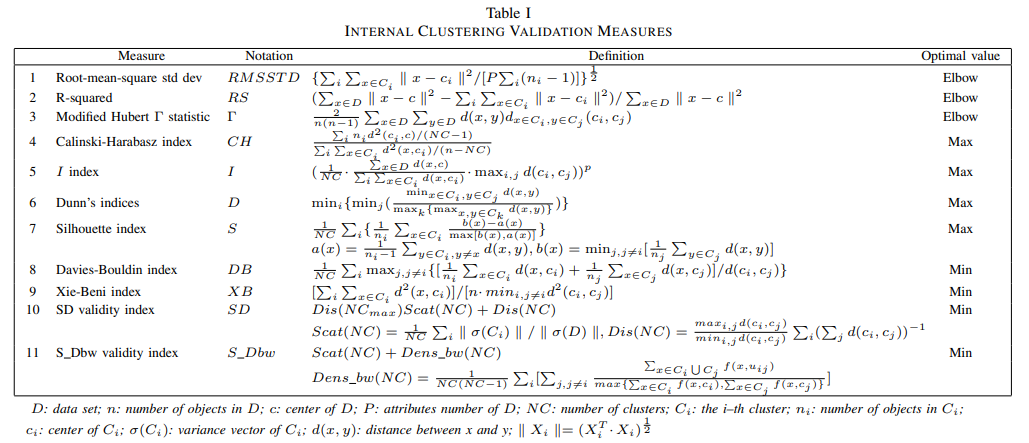

## 2. Expectation-maximization based approaches

### 2.1. k-means algorithm

The k-means algorithm is the simplest and most intuitive clustering algorithm. It performs remarkably well under a number of assumptions:

* Number of clusters are known
* Clusters are roughly spherical
* Clusters are separated by linear boundaries

Even if these assumptions are violated, it often works anyway, especially in high dimensions (the "blessing" of dimensionality).

The k-means algorithm works using the principal of **expectation-maximization**. This is an iterative type of algorithm that contains two basic steps:

* Expectation: Assign points based on some "expectation" metric.
* Maximization: Revise expectations based on maximizing a fitness metric.

In the case of k-means we:

* Expect that points close to the center of a cluster belong to that cluster
* Maximize the proximity of points to the center of a cluster by moving the center

This process is interated until convergence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

np.random.seed(0)

In [2]:
def show_data(X, label=None, centroids=None, cmap='tab10', colorbar=False):
    plt.figure(figsize=(5+int(colorbar),5))
    plt.scatter(*X.T, c=label, cmap=cmap)
    if colorbar:
        plt.colorbar()
    if centroids is not None:
        plt.scatter(*centroids.T, marker='*', c='green', s=100)
    plt.show()

<ipython-input-2-9e40f8db2dfb>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*X.T, c=label, cmap=cmap)


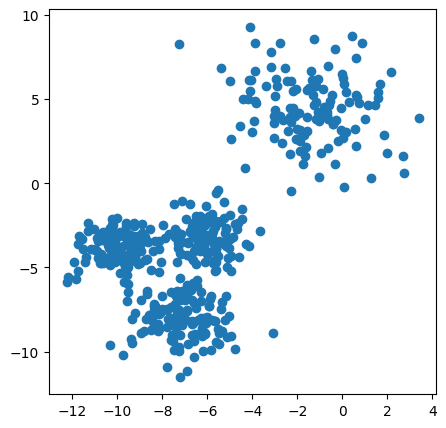

In [3]:
X, y = datasets.make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[2.0, 0.9, 1.2, 1.1], center_box=(-10.0, 10.0), random_state=1)
show_data(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


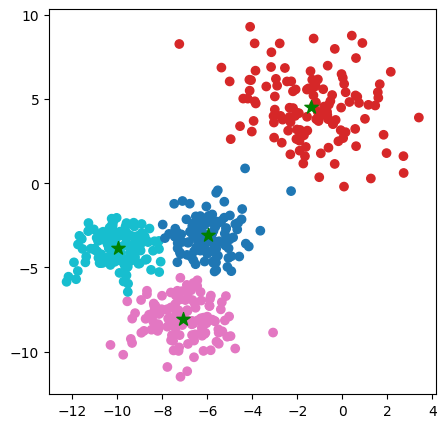

In [4]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4)
cluster_labels = km.fit_predict(X)

show_data(X, cluster_labels, centroids=km.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


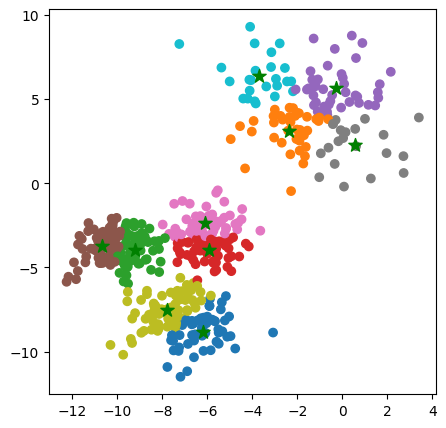

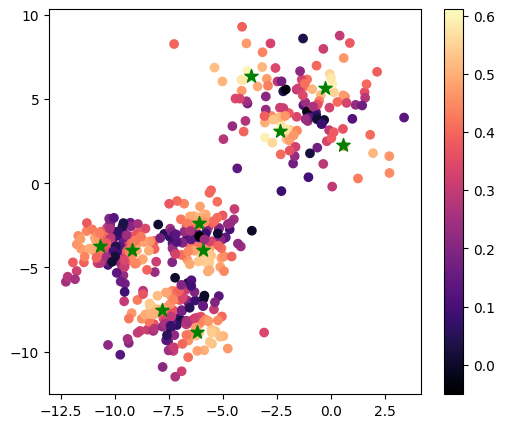

Average silhouette score: 0.3276799486223794


In [5]:
from sklearn.metrics import silhouette_samples, silhouette_score

k = 10
km = KMeans(n_clusters=k)
cluster_labels = km.fit_predict(X)

show_data(X, cluster_labels, centroids=km.cluster_centers_)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)
avg_silhouette_score = silhouette_score(X, cluster_labels)
show_data(X, sample_silhouette_values, centroids=km.cluster_centers_, cmap='magma', colorbar=True)
print('Average silhouette score:', avg_silhouette_score)

What happens when we select a different value of k?

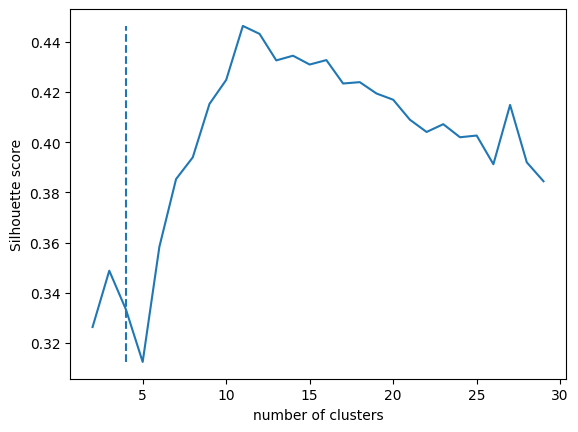

In [19]:
#
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import silhouette_score

silhouette_scores = []

K = range(2, 30)
for k in range(2,30):
    km = KMeans(n_clusters=k)
    cluster_labels = km.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

plt.plot(K, silhouette_scores)
plt.xlabel('number of clusters')
plt.ylabel('Silhouette score')

plt.vlines(4, min(silhouette_scores), max(silhouette_scores), linestyles='dashed')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


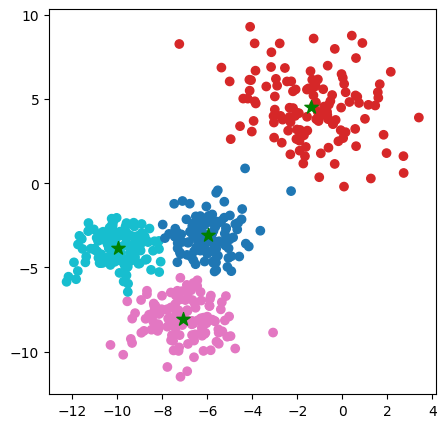

In [7]:
km = KMeans(n_clusters=4)
cluster_labels = km.fit_predict(X)

show_data(X, cluster_labels, centroids=km.cluster_centers_)

### 2.2. Gaussian mixture models

Gaussian mixture models, or GMM's, are another clustering approach based on expectation maximization. The approach is to model each cluster as a Gaussian distribution, and to model the entire dataset as a mixture of Gaussians. Mathematically:

$ P(\vec{x}) = \sum_k \phi_k \mathcal{N}(\vec{x}, \vec{\mu}, \vec{\sigma})$

where $\mathcal{N}$ is the normal distribution:

* one dimension: $N(x, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left( \frac{-(x-\mu)^2}{2 \sigma ^2} \right)$

* multi-dimensional: $N(\vec{x}, \vec{\mu}, \underline{\underline{\Sigma}}) = \frac{1}{(2 \pi |\underline{\underline{\Sigma}}|)} \exp \left( \frac{1}{2} (\vec{x} - \vec{\mu})^T \underline{\underline{\Sigma}}^{-1}  (\vec{x} - \vec{\mu}) \right)$

where $\underline{\underline{\Sigma}}$ is the covariance matrix.

#### (E-Step) Expectation step:

We can calculate the expected probability that a point $i$ is in a cluster $k$ with the following formula for a 1d Gaussian:

$\gamma_{ik} = \frac{\phi_k \mathcal{N}(\vec{x}_i, \vec{\mu}_k, \vec{\sigma}_k)}{\sum_j \phi_j \mathcal{N}(\vec{x}_i, \vec{\mu}_j, \vec{\sigma}_j)}$

#### (M-Step) Maximization step:

The parameters of the distributions can then be updated by calculating the maximum likelihood estimators for $\phi$, $\mu$, and $\sigma$, similar to the way these parameters would be estimated for a single distribution:

* $\phi_k = \sum_{i=1}^N \frac{\gamma_{ik}}{N}$
* $\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} x_i}{\sum_{i=1}^N \gamma_{ik}} $
* $\sigma_k = \frac{\sum_{i=1}^N \gamma_{ik} (x_i - \mu_k)^2}{\sum_{i=1}^N \gamma_{ik}} $

These parameters are derived by maximizing $P(\vec{x})$ with respect to each parameter. The formulas for multi-dimensional Gaussians are derived in the same way but are more complex.

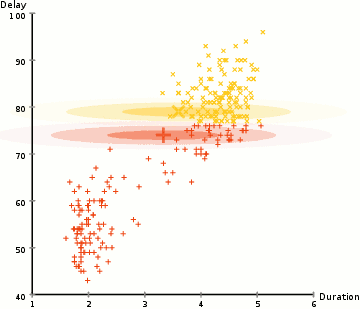

> Question: In a d-dimensional space with k clusters how many total numbers/parameters are needed to define the Gaussian mixture model?

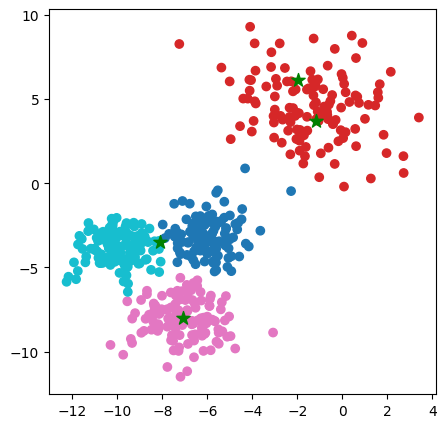

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
gmm.fit(X)

show_data(X, cluster_labels, centroids=gmm.means_)

## 3. Density-based models

Density-based clustering algorithms consider local density of points and utilize this information to group points into clusters.

### 3.1. Mean shift algorithm

The simplest density-based algorithm is the "mean shift" algorithm. This is similar to k-means in that we seek the centroid of each cluster. The difference is that in mean shift the number of clusters does not need to be specified. Instead a "window" is specified, and at each iteration the centroids are updated to centroid of all points in each window.

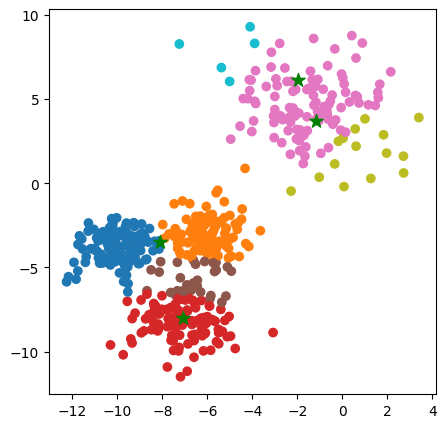

In [9]:
from sklearn.cluster import MeanShift
clustering = MeanShift(bandwidth=2).fit(X)
clustering.labels_

show_data(X, clustering.labels_, centroids=gmm.means_)

> What happens as we increase or decrease the bandwidth? Can you find a good clustering of these data?

### 3.2. DBSCAN

The DBSCAN algorithm also uses a local sliding window similar to mean shift, but instead of defining clusters by centroids it defines the cluster by whether or not a point falls within the sliding window. We will not go through the algorithm in detail, but the general steps are:



1.   Start with a random point and find its neigbhors within distance $r$.
2.   If there are a sufficient number of neigbhors (defined by a minimum points argument) then the clustering process starts. If not then the point is labeled as noise and a new point is selected until the clustering process starts.
3.   The neighbors within a distance $r$ are added to the cluster.
4.   The nearest neighbor is selected as the next point, and the same process is repeated until all points within distance $r$ of any point within a cluster are defined as being part of that cluster.
5.   Once a cluster has finished, a new point is selected and a new cluster is started. The process is repeated until all points have been assigned to a cluster or labeled as noise.

The key **hyperparameters** are:
*   r - the radius to include in a cluster
*   min_samples - the minimum number of samples within a radius of $\epsilon$ such that a point is not considered noise.


A key advantage of DBSCAN is that it can find clusters with highly nonlinear structures!

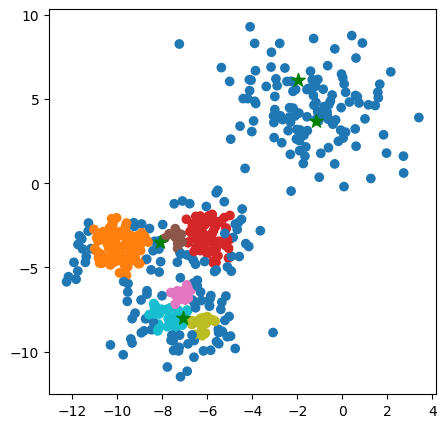

In [10]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.5, min_samples=10)
y_predict = model.fit_predict(X)

show_data(X, y_predict, centroids=gmm.means_)

Let's look at some more complex datasets with nonlinear boundaries!

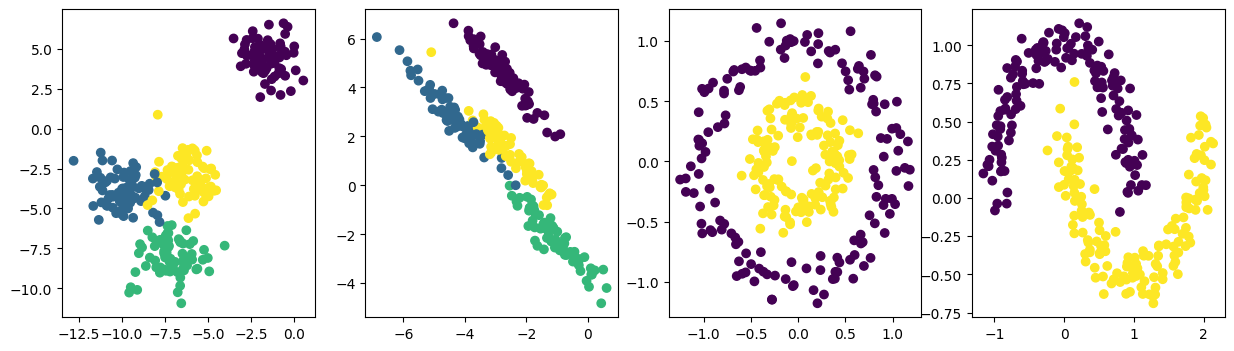

In [11]:
from sklearn.datasets import make_blobs, make_moons, make_biclusters, make_circles
from sklearn.metrics import silhouette_samples, silhouette_score
#calinski_harabaz_score

random_state = 1
k = 4
N = 300

X_blobs, y_blobs = make_blobs(N,centers=k,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_blobs, transformation)

X_circles, y_circles = make_circles(N,noise=0.1, factor=0.4, random_state=random_state)

X_moons, y_moons = make_moons(N, noise=0.1, random_state=random_state)

fig, axes = plt.subplots(1,4, figsize=(15,4))

axes[0].scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs)
axes[1].scatter(X_aniso[:,0], X_aniso[:,1], c=y_blobs)
axes[2].scatter(X_circles[:,0], X_circles[:,1], c=y_circles)
axes[3].scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

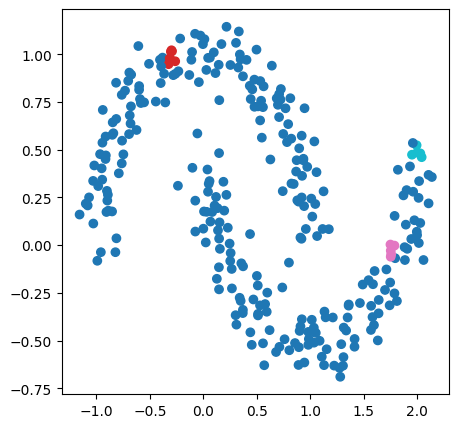

In [12]:
model = DBSCAN(eps=0.05, min_samples=5)
y_predict = model.fit_predict(X_moons)

show_data(X_moons, y_predict)

> How do the hyperparameters impact clustering performance in this case?

What if we increase the number of samples from the same underlying generative model (i.e., increase the density)?

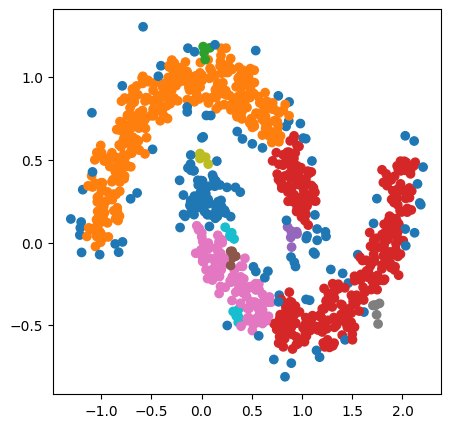

In [13]:
X_moons2, y_moons2 = make_moons(1000, noise=0.1, random_state=random_state)

model = DBSCAN(eps=0.07, min_samples=5)
y_predict = model.fit_predict(X_moons2)

show_data(X_moons2, y_predict)

## 4. Graph-based approaches

### 4.1. Spectral Clustering

1. Compute the adjacency and degree matrices for your graph (or dataset)
2. Compute the graph Laplacian (e.g., L = D-A)
3. Calculate the eigenvectors corresponding to the k smallest eigenvalues of L
4. Consider the matrix formed by these k eigenvectors. The l-th row defines the features of graph node l.
5. Cluster the graph nodes based on these features (e.g., using k-means clustering)

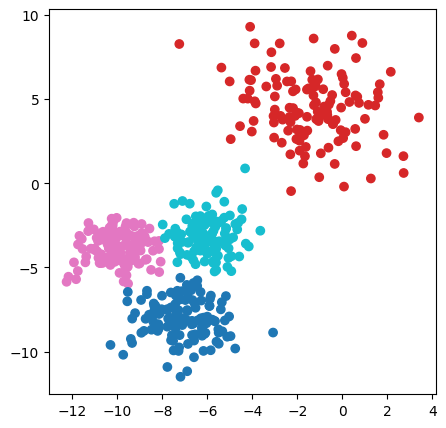

In [14]:
# Spectral clustering
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=4)
cluster_labels = sc.fit_predict(X)

show_data(X, cluster_labels)

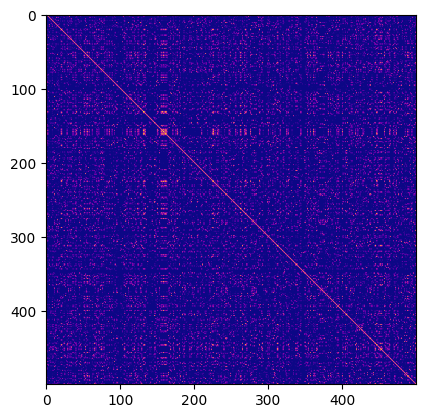

In [15]:
plt.imshow(sc.affinity_matrix_,cmap='plasma')

> Question: What does the affinity matrix look like after being sorted by its predicted labels?

## 5. Hierarchical Approaches

### 5.1. Dendrograms

A "dendrogram" is a graphical representation of the distances between different points in some high-dimensional space. One intuitive but qualitative example of a dendrogram are the [species trees](https://www.instituteofcaninebiology.org/how-to-read-a-dendrogram.html) commonly used in biology:



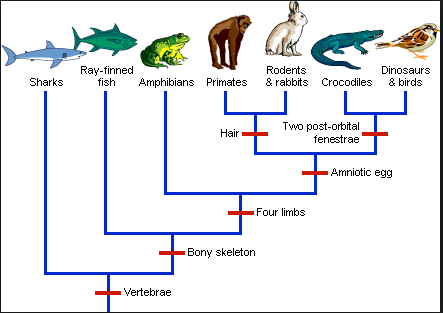

We can see that it is possible to create different "clusters" of species based on different defining characteristics. By choosing more or less specific "cutoffs" we could create a few large clusters or many small clusters. The idea is similar for data sets. Let's see how it looks for some of our examples.

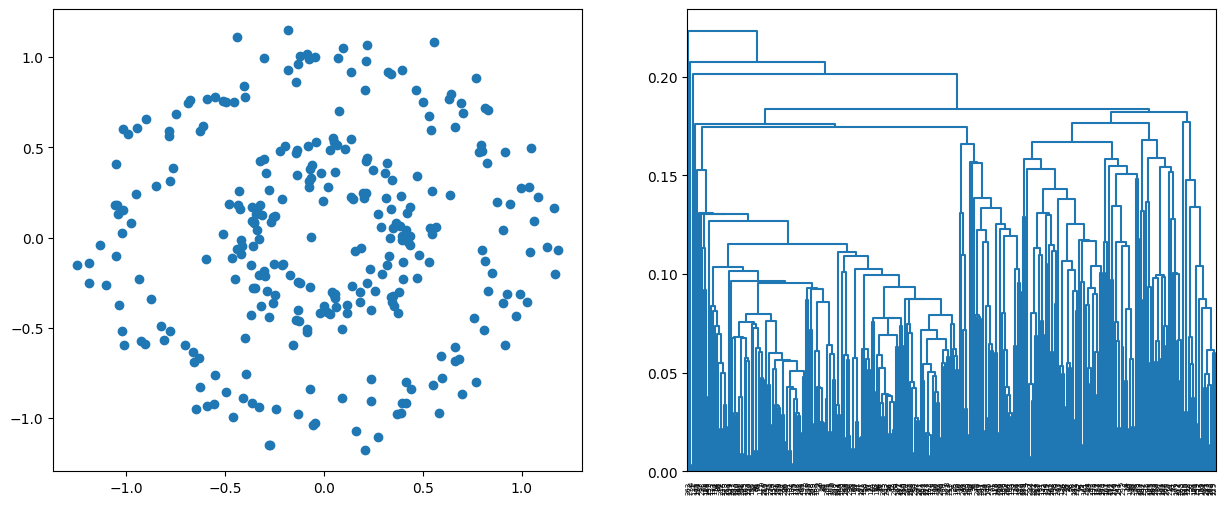

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = X_circles
Z = linkage(X, method='single')
fig, axes = plt.subplots(1,2, figsize=(15,6))
dendrogram(Z, color_threshold=0, ax=axes[1])
axes[0].scatter(X[:,0],X[:,1])

Note that we passed a "method" argument into the linkage. This describes the method that is used to calculate the distance between two clusters that have multiple points. There are more details available [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), but a very qualitative descripton of some of the options:

* `single`: take the minimum distance between any two points in the two clusters
* `complete`: take the maximum distance between any two points in the two clusters
* `average`: use an average of distances between points in the two clusters
* `weighted`: weight distances differently between the agglomerated cluster and one being added
* `centroid`: use the distance between cluster centroids
* `ward`: use the distance that minimizes the variance between the clusters

So, which one should we choose? This is where we can use the "cophenetic coefficient", which measures the ratio of the distance in "linkage" space to the distance in the high-dimensional space.

> Question: Check out some of the different distance metrics and other hyperparameters of these models online.

This example examines the impact of different linkage models on a number of toy clustering datasets ([EXAMPLE](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html))

### 5.2. Agglomerative hierarchical clustering

Agglomerative clustering is easy to understand once the "linkage" structure makes sense. The number of clusters can be defined either explicitly (move up the tree until there are 'k' clusters) or implicitly (provide a linkage distance that defines separate clusters).


The mechanics of doing this can be a little tricky, but luckily there are built-in functions to help:

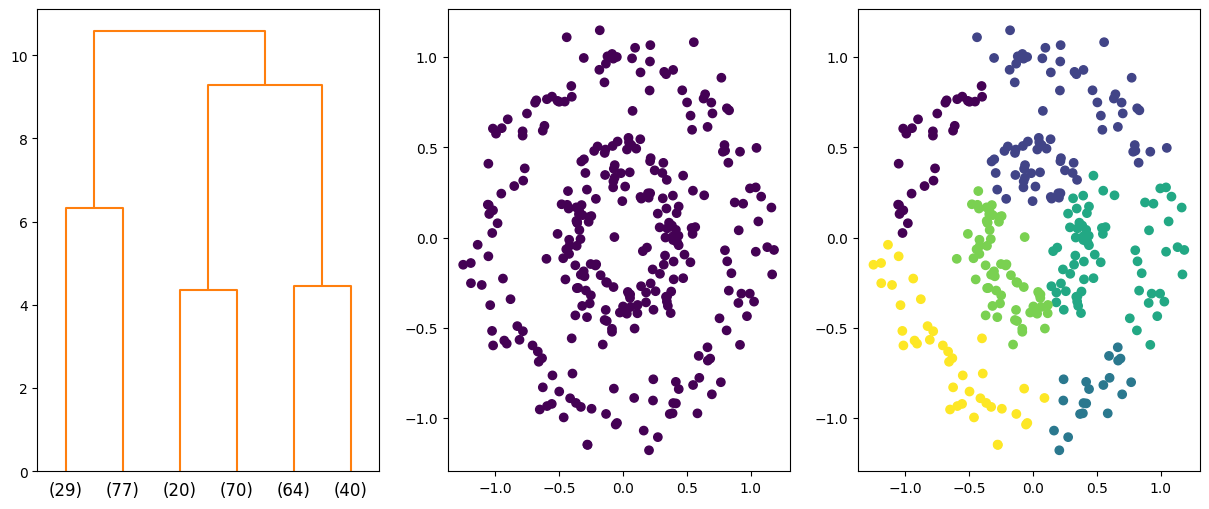

In [17]:
from scipy.cluster.hierarchy import fcluster

max_d = 20
k = 6

Z = linkage(X,method='ward')
clusters_dist = fcluster(Z, max_d, criterion='distance')
clusters_k = fcluster(Z, k, criterion='maxclust')

fig, axes = plt.subplots(1,3, figsize=(15,6))
dendrogram(Z, color_threshold=max_d, truncate_mode='lastp', p=k, ax=axes[0])
axes[1].scatter(X[:,0],X[:,1],c=clusters_dist)
axes[2].scatter(X[:,0],X[:,1],c=clusters_k)

There are options for determining the cutoffs automatically, but none of them are great! The most common is the inconsistency method, which monitors for "jumps" in the distance:

* $I = \frac{h-avg}{std}$
    - $h$: merge height of cluster (length in y-directon on dendrogram)
    - $avg$: average height of last $d$ merges
    - $std$: standard deviation of last $d$ merges
    
If $I >= t$ where t is a specified threshold then this will be used as the cutoff. Let's see how it performs:

Number of clusters: 20


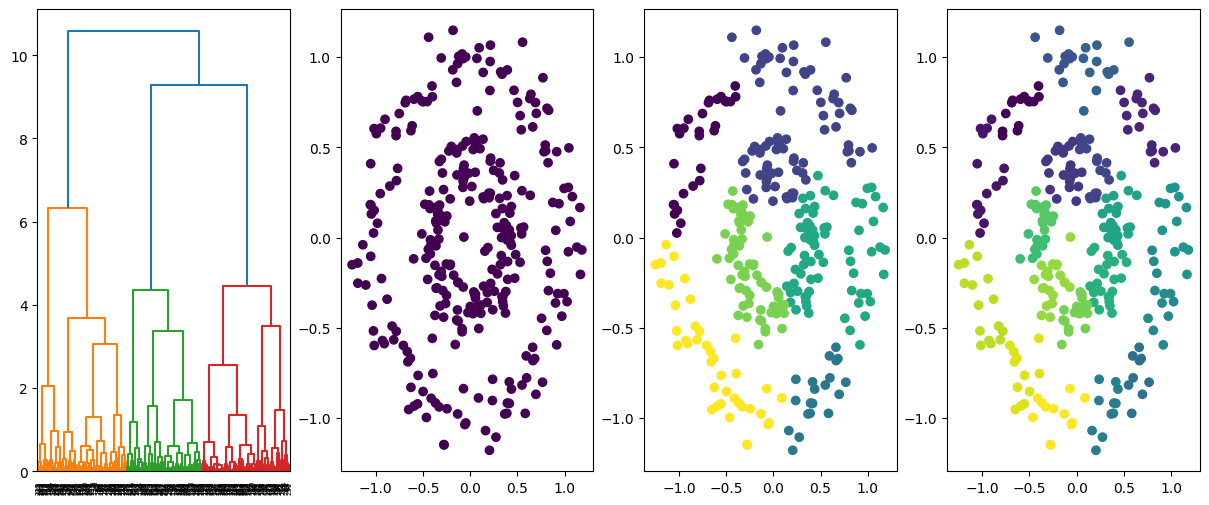

In [18]:
I_cutoff = 3.5
clusters_I = fcluster(Z, I_cutoff, criterion='inconsistent', depth=10)

fig, axes = plt.subplots(1,4, figsize=(15,6))
dendrogram(Z, ax=axes[0])
axes[1].scatter(X[:,0],X[:,1],c=clusters_dist)
axes[2].scatter(X[:,0],X[:,1],c=clusters_k)
axes[3].scatter(X[:,0],X[:,1],c=clusters_I)
print('Number of clusters:', max(clusters_I))

## Conclusions

* Clustering algorithms are **unsupervised** and are often used for exploratory data analysis.
* Assessing the accuracy of clustering methods is challenging if the labels are not known.
* Distance metrics can make a big difference in how clustering algorithms perform.
* Three types of algorithms were discussed:
    -  Expectation Maximization
    -  Density-based
    -  Hierarchical
* Some considerations for choosing an algorithm:
    -  Is the number of clusters known?
    -  Are data points expected to belong to a single cluster, or is **mixed membership** expected?
    -  Is noise expected in the data?
* Clustering algorithms are useful for:
    -  Data compression (vector quantization)
    -  Searching data
    -  Grouping data
    -  Establishing intuition
* When clustering data it is a good idea to try many approaches with difference distance/error metrics to get a feel for which factors are important.

* If possible, visualizing the data directly can provide substantial intuition about which methods will perform best.
* Dendrograms are a useful way to indirectly visualize data in a high-dimensional space, and the difference between a dendrogram and a direct measure of distance can be quantified with the **cophenetic coefficient**.

Contributors: Mehdi Azabou, Eva Dyer